# Latent Dirichlet Allocation (LDA)

LDA это вероятностная тематическая модель. Совместное распределение имеет следующий вид:
$$p(W, Z, \Theta, \Phi | \alpha, \eta) = \prod_{d=1}^D \Big( p(\theta_d | \alpha) \prod_{n=1}^{N_d} p(w_{d,n} | z_{d,n}, \Phi) p(z_{d,n} | \theta_d) \Big) \prod_{t=1}^T p(\phi_t | \eta) $$

Где:
$$p(\theta_d | \alpha) = Dir(\theta_d | \alpha)$$

$$p(w_{d,n} | z_{d,n}, \Phi) = Categorical(W_{d,n} | \phi_{z_{d,n}})$$

$$p(z_{d,n} | \theta_d) = Categorical(z_{d,n} | \theta_d)$$

$$p(\phi_t | \eta) = Dir(\phi_t | \eta)$$

В данном задании, вам предстоит применить тематическую модель LDA к датасету NIPS-papers. Нужно установить Python библиотеку `gensim` (её можно установить с помощью `pip`).

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

import gensim

import logging

gensim.models.ldamodel.logger.setLevel(logging.ERROR)

D:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Скачайте датасет и поместите его в папку с ноутбуком: 
http://www.cs.nyu.edu/~roweis/data/nips12raw_str602.mat

Код ниже выполняет необходимую предобработку данных.

In [5]:
nips12 = scipy.io.loadmat('nips12raw_str602.mat', squeeze_me=True)

# матрица размера <число документов> x <число слов>
counts = nips12['counts'].T

# оставим 2013 (~2000) наиболее употребимих слов
words_mask = np.ravel(counts.sum(axis=0) >= 121)
counts = counts[:, words_mask]

# отображение id -> word (необходимо для gensim)
nips12_id2word = {i: w for (i, w) in enumerate(nips12['wl'][words_mask])}

# отображение word -> id (необходимо для pyLDAvis)
nips12_word2id = {w: i for (i, w) in enumerate(nips12['wl'][words_mask])}

# Год проведения конференции. Значение 0 соответсвует 1988, 1 - 1989, и т.д.
nips12_issue = np.array([int(name[4:6]) for name in nips12['docnames']])

# Заголовки статей
nips12_titles = nips12['ptitles']

# Полный корпус в формате gensim
full_corpus = gensim.matutils.Scipy2Corpus(counts)

stream = np.random.RandomState(seed=123)
subset_mask = stream.rand(counts.shape[0]) <= 0.1

# Маленький корпус из 10% случайных статей для ускорения экспериментов
small_corpus = gensim.matutils.Scipy2Corpus(counts[subset_mask, :])

Gensim использует итеративный подход к выводу в модели LDA. Для получения новых значений вариационных параметров выполняется `iterations` итераций вариационного вывода. Далее, новые значения "блэндятся" со старыми (значениями из предыдущей итерации EM-алгоритма) посредством вычисления взвешенного среднего. Эта процедура повторяется `num_passes` раз. Такой подход позволяет предотвратить "застревание" метода в локальных оптимумах.

Используйте следующий шаблон для запуска LDA модели в Gensim. Сейчас мы используем подвыборку для ускорения вычислений.

Замечание: нижняя оценка связана с метрикой perplexity, которая обычно используется в естественных языках: $perplexity = exp(-bound)$

In [3]:
num_topics = 10  # число тем в модели LDA
# параметры априорного распределения Дирихле над распределениями документ/тема
alpha = [0.1] * num_topics
iterations = 50  # число итераций вариационного вывода
num_passes = 5  # число проходов по датасету


small_lda = gensim.models.LdaModel(
    corpus=small_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42
)
print('ELBO = {0:.4f}'.format(small_lda.bound(small_corpus)))

ELBO = -1494880.4356


Исследуйте влияние значений параметров `iterations` и `num_passes` на значние нижней оценки обученной модели.

In [4]:
def lower_bound(num_topics, alpha, iterations, num_passes, corpus):
    small_lda = gensim.models.LdaModel(
        corpus=corpus,
        passes=num_passes,
        num_topics=num_topics,
        alpha=alpha,
        iterations=iterations,
        id2word=nips12_id2word,
        eval_every=0,
        random_state=42
    )
    return small_lda.bound(small_corpus)

In [5]:
num_topics = 10
alpha = [0.1] * num_topics
num_passes_list = np.linspace(1, 99, 25).astype(int)
iterations_list = np.linspace(10, 990, 25).astype(int)

In [6]:
lb_list_iter = []
for i in tqdm(range(25)):
    lb_list_iter.append(lower_bound(num_topics, alpha, iterations_list[i], num_passes, small_corpus))

A Jupyter Widget

In [7]:
lb_list_passes = []
for i in tqdm(range(25)):
    lb_list_passes.append(lower_bound(num_topics, alpha, iterations, num_passes_list[i], small_corpus))

A Jupyter Widget

In [8]:
lb_list_both = []
for i in tqdm(range(25)):
    lb_list_both.append(lower_bound(num_topics, alpha, iterations_list[i], num_passes_list[i], small_corpus))

A Jupyter Widget

D:\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


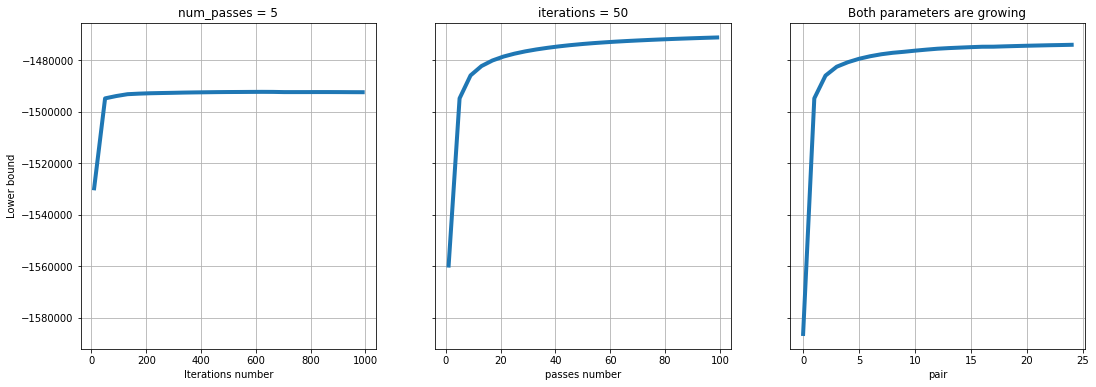

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
ax1.plot(iterations_list, lb_list_iter, linewidth=4)
ax1.set_ylabel("Lower bound")
ax1.set_xlabel("Iterations number")
ax1.set_title("num_passes = 5")
ax1.grid(True)

ax2.plot(num_passes_list, lb_list_passes, linewidth=4)
ax2.set_xlabel("passes number")
ax2.set_title("iterations = 50")
ax2.grid(True)

ax3.plot(range(25), lb_list_both, linewidth=4)
ax3.set_xlabel("pair")
ax3.set_title("Both parameters are growing")
ax3.grid(True)

fig.show();

Видно, что увеличение количества итераций как и до блендинга, так и после уточняет нижнюю границу. Однако на графиках мы явно видим насыщение, что бы мы ни увеличивали.

Исследуйте чувствительность нижней вариационную оценки к параметру априорного распределения $\alpha$. Используйте симметричные значения $\alpha$.

In [10]:
alpha_list = [[x] * num_topics for x in np.linspace(1e-6, 3, 30)]

In [11]:
lb_list_alpha = []
for i in tqdm(range(30)):
    lb_list_alpha.append(lower_bound(num_topics, alpha_list[i], iterations, num_passes, small_corpus))

A Jupyter Widget

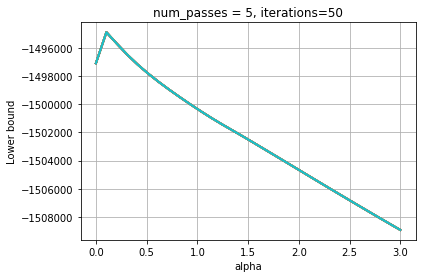

In [12]:
plt.plot(alpha_list, lb_list_alpha, linewidth=2)
plt.ylabel("Lower bound")
plt.xlabel("alpha")
plt.title("num_passes = 5, iterations=50")
plt.grid(True)
plt.show()


Обучите лучшую найденую модель на полной выборке.

In [17]:
num_topics = 10  # число тем в модели LDA
# параметры априорного распределения Дирихле над распределениями документ/тема
alpha = alpha_list[np.argmax(lb_list_alpha)]
iterations = 400  # число итераций вариационного вывода
num_passes = 40  # число проходов по датасету

lda = gensim.models.LdaModel(
    corpus=full_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42,
)
print('ELBO = {0:.4f}'.format(lda.bound(full_corpus)))

ELBO = -13787432.5098


Извлеките вариационные параметры $\gamma$ &mdash; параметры вариационной аппроксимации апостериорных вероятностей тем для документов: $q(\Theta_d) = Dir(\Theta_d | \gamma_d)$.

Нормализуйте их так, чтобы получить вероятностное распределение над темами для каждого документа (средние значения вероятностей в соответствии с распределением Дирихле).

In [31]:
gamma, _ = lda.inference(full_corpus)
#нормализуйте gamma
gamma = gamma / gamma.sum(axis=1)[:,None]

Изобразите полученное апостериорное распределение вероятностей тем для нескольких документов. Сделайте это для документов разных годов. Меняется ли разреженность тем с течением времени? Как можно это объяснить?


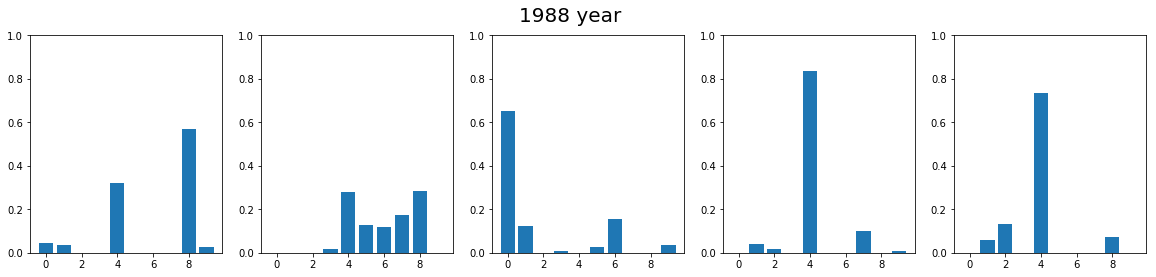

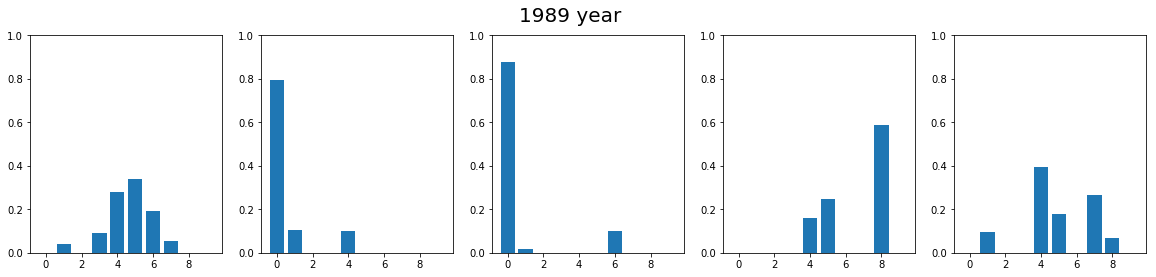

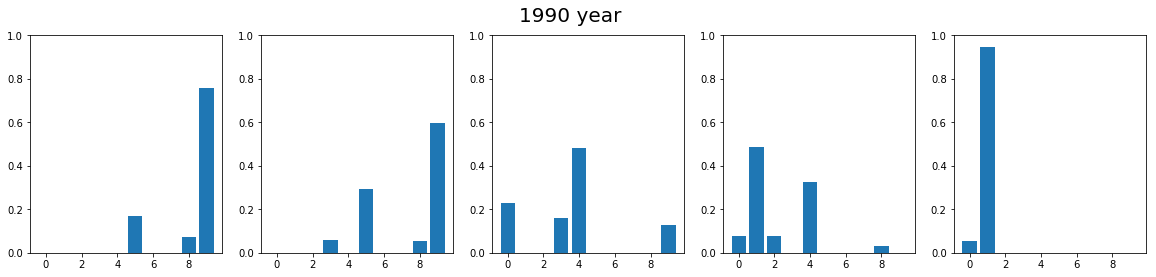

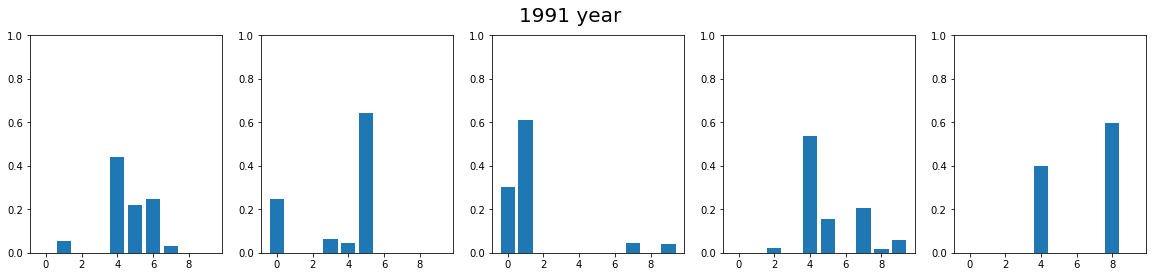

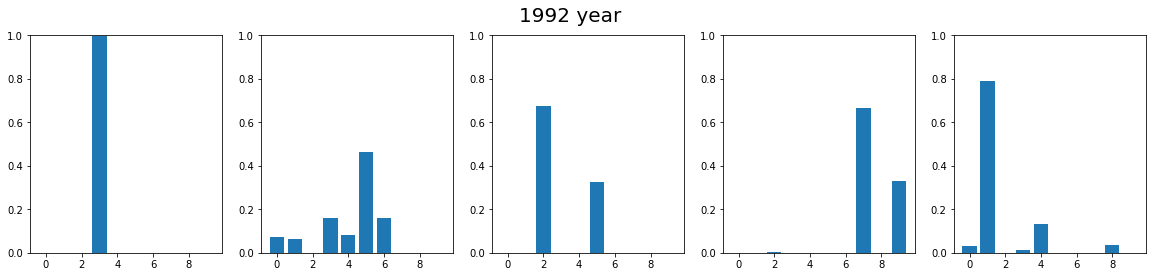

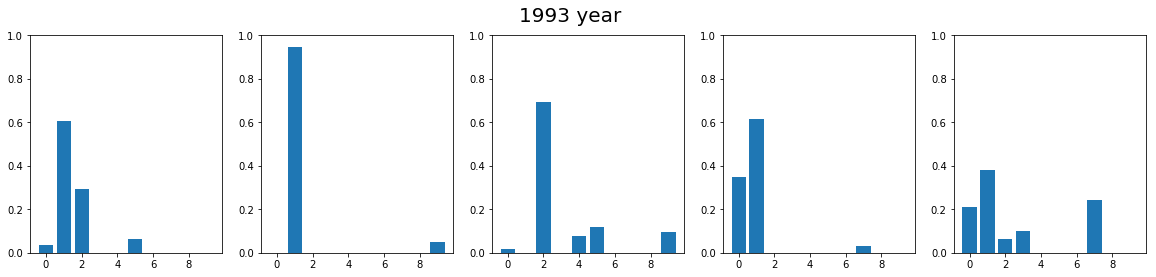

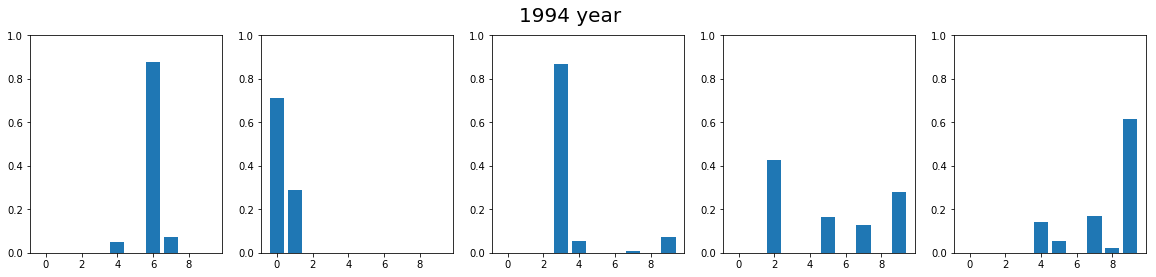

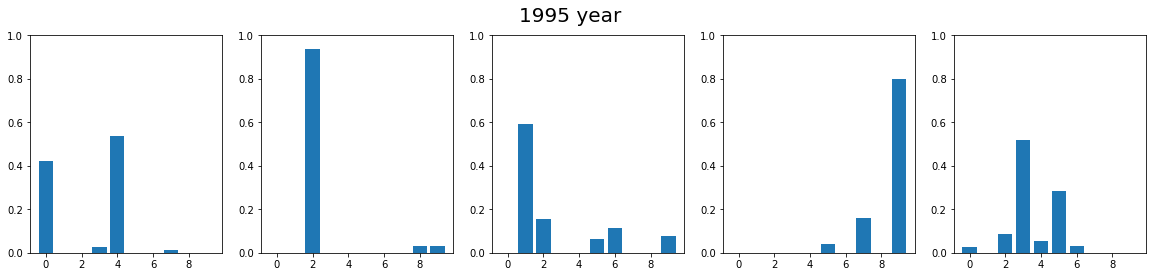

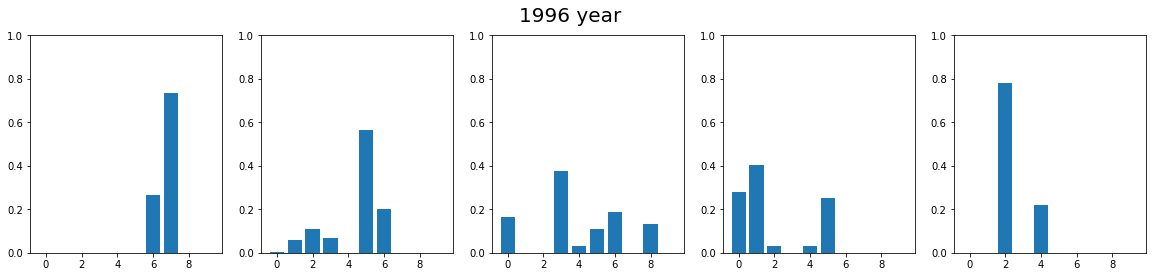

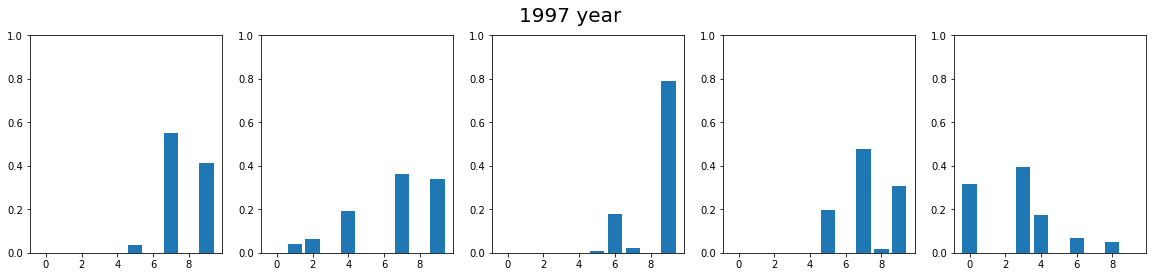

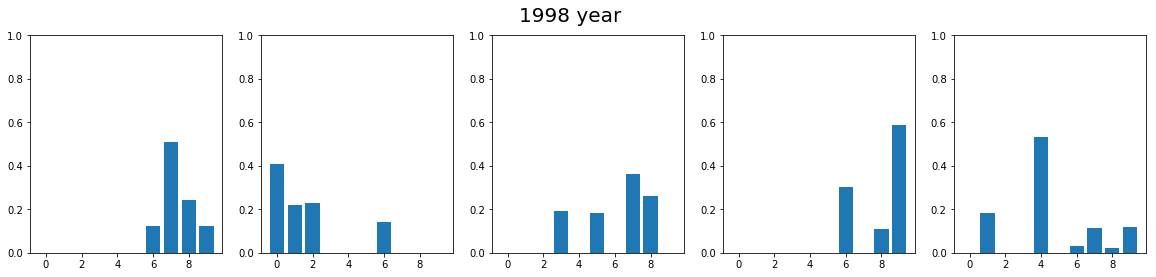

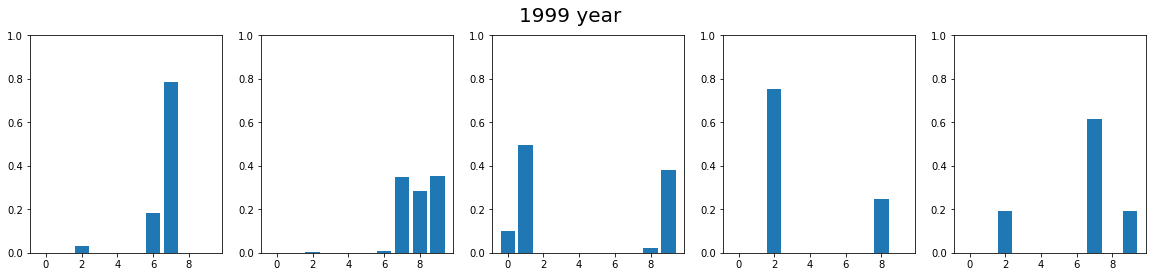

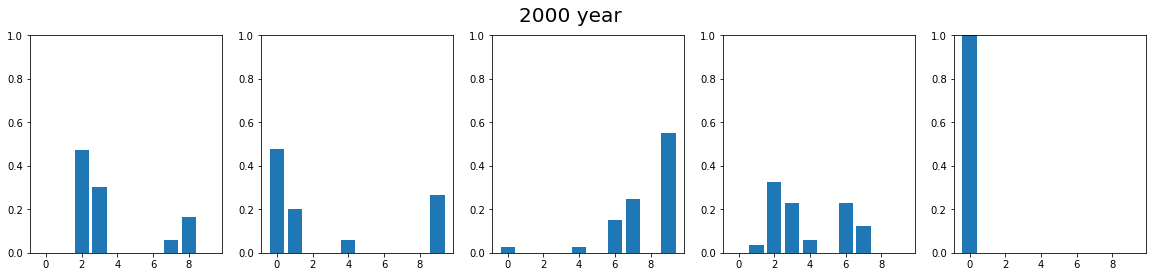

In [50]:
for i in range(13):
    current = np.where(nips12_issue == i)[0]
    np.random.shuffle(current)
    articles = current[:5]
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,4))
    fig.suptitle('%i year' % (1988 + i), fontsize=20)
    ax1.bar(range(10), gamma[articles[0], :])
    ax1.set_ylim(0,1)
    ax2.bar(range(10), gamma[articles[1], :])
    ax2.set_ylim(0,1)
    ax3.bar(range(10), gamma[articles[2], :])
    ax3.set_ylim(0,1)
    ax4.bar(range(10), gamma[articles[3], :])
    ax4.set_ylim(0,1)
    ax5.bar(range(10), gamma[articles[4], :])
    ax5.set_ylim(0,1)
    plt.show()
    plt.close()

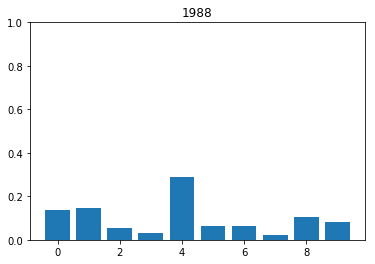

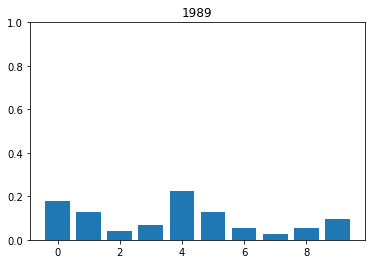

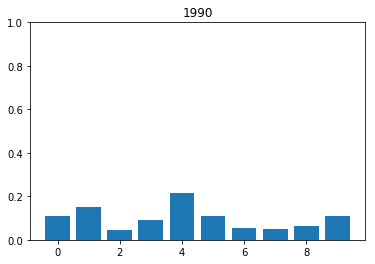

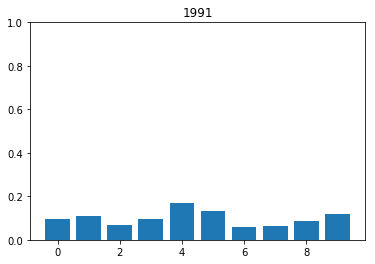

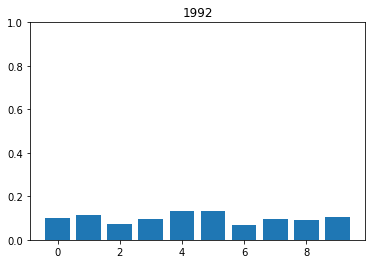

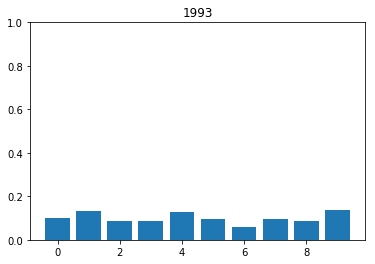

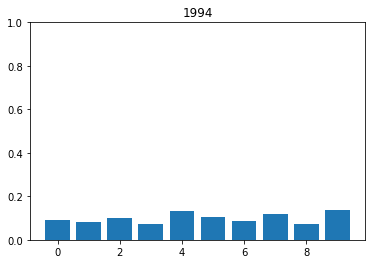

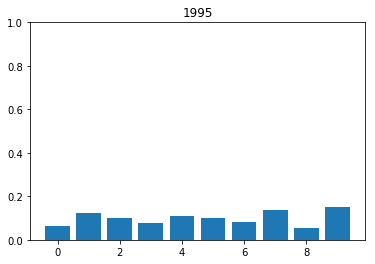

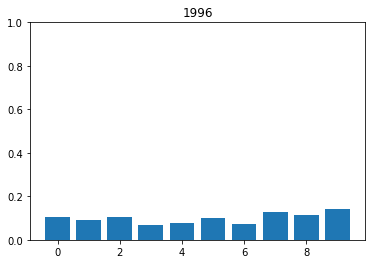

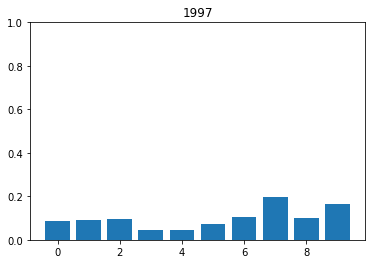

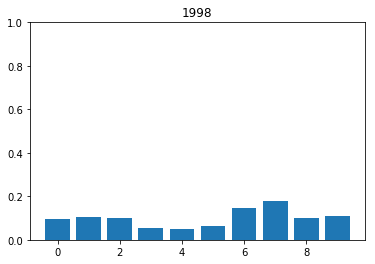

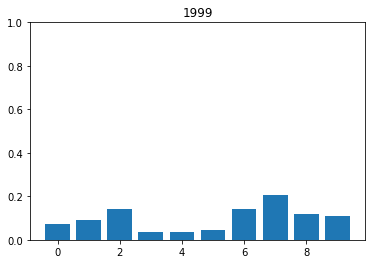

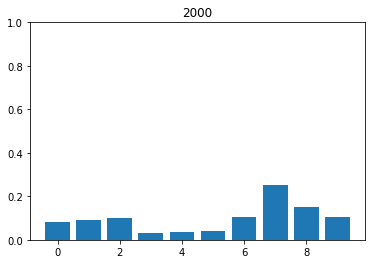

In [52]:
for i in range(13):
    current = np.where(nips12_issue == i)[0]
    plt.bar(range(10), gamma[current].mean(axis=0))
    plt.title('%i' % (1988 + i))
    plt.ylim(0,1)
    plt.show()
    plt.close()

---
Видно, что распределение меняется со временем,, в частности, последние темы становятся более распространенными, что может говорить о тенденциях.

---

Выведите наиболее вероятные слова и наиболее вероятные документы для каждой темы. Воспользуйтесь функциями `lda.num_topics`, `lda.show_topic(topic, topn=10)`. Используйте нормализованные параметры $\gamma$, вычисленные ранее.

Проанализируйте результат. Как вы можете интерпретировать темы? Напишите ваши интерпретации хотя бы для трёх тем.

Замечание. Если вы нашли интересную статью в списке, вы можете скачать её онлайн, публикации конференции NIPS доступны бесплатно.

---
Посмотрим на топовые слова по темам

In [57]:
for i in range(10):
    print("%i topic" % (1+i))
    for word in lda.show_topic(i, topn=10):
        print(word)
    print()

1 topic
('time', 0.013133634603509815)
('neuron', 0.011836958582686158)
('figure', 0.011307647819083232)
('neurons', 0.010358253828767707)
('model', 0.010054509104616081)
('cell', 0.0088463822978966638)
('spike', 0.0082860959465363253)
('circuit', 0.008265670496568088)
('input', 0.0081146380607301262)
('system', 0.0073795716692475226)

2 topic
('model', 0.01817696853131465)
('visual', 0.011553117700818528)
('activity', 0.0091250314177667314)
('input', 0.0086637098855881639)
('cells', 0.0085176484288308121)
('figure', 0.0082829051344477655)
('neurons', 0.0076034269531105028)
('cortex', 0.0070605070944034396)
('network', 0.0061198052321734756)
('orientation', 0.0057085817801567013)

3 topic
('learning', 0.027848836086775918)
('state', 0.024786393493058622)
('time', 0.015874439094836261)
('control', 0.014888111562612246)
('model', 0.014121189070791214)
('function', 0.0086571835741284641)
('system', 0.0085620404579917191)
('algorithm', 0.0079465171211679751)
('reinforcement', 0.00755143237

---
2 Brain modeling or interface

4 Speech recognition

7 Image processing

10 Special regularization for different noises


In [71]:
for i in range(10):
    print('Topic %i' % (1+i))
    print(nips12['ptitles'][np.argmax(gamma[:,i])])

Topic 1
An Analog VLSI Model of Periodicity Extraction,
Topic 2
OCULAR DOMINANCE AND PATTERNED LATERAL CONNFL-TIONS IN A SELF-ORGANIZING MODEL OFTHE PRIMARY VISUAL CORTEX 
Topic 3
Memory-based Reinforcement Learning: Efficient Computation with Prioritized Sweeping 
Topic 4
Spoken Letter Recognition . 
Topic 5
Back Propagation Implementation . 
Topic 6
Learning Statistically Neutral Tasks without Expert Guidance,
Topic 7
Two-Dimensional Object Localization by Coarse-to-Fine Correlation Matching 
Topic 8
Stacked Density Estimation,
Topic 9
Neural Computing with Small Weights 
Topic 10
Learning with Noise and Regularizers in Multilayer Neural Networks, 


Вычислите среднюю вероятность тем для каждого года. Проанализируйте какие темы становятся более популярны с теченим времени, а какие, наоборот, теряют популярность.

---
Сделал выше

---

Используйте следующий код для отображения тем, найденных LSI (Latent Semantic Indexing) &mdash; невероятностной тематической моделью. Как можно интерпретироват полученные темы? Сравните время работы методов.

In [72]:
lsi = gensim.models.LsiModel(
    full_corpus, num_topics=num_topics, id2word=nips12_id2word)
lsi.print_topics(10, num_words=20)

[(0,
  '0.293*"network" + 0.263*"learning" + 0.207*"model" + 0.204*"neural" + 0.188*"input" + 0.167*"training" + 0.167*"data" + 0.164*"networks" + 0.162*"time" + 0.161*"function" + 0.158*"set" + 0.152*"figure" + 0.127*"output" + 0.119*"algorithm" + 0.118*"error" + 0.113*"number" + 0.109*"system" + 0.107*"units" + 0.104*"state" + 0.094*"results"'),
 (1,
  '-0.498*"network" + 0.334*"learning" + -0.222*"input" + 0.209*"algorithm" + 0.208*"data" + 0.196*"model" + -0.188*"neural" + -0.167*"networks" + -0.158*"units" + -0.151*"output" + 0.128*"state" + 0.123*"function" + -0.115*"layer" + -0.096*"unit" + -0.090*"neurons" + 0.088*"models" + 0.080*"distribution" + -0.078*"hidden" + 0.077*"policy" + 0.075*"optimal"'),
 (2,
  '0.473*"model" + -0.238*"training" + -0.228*"learning" + -0.205*"network" + 0.179*"cells" + -0.174*"error" + 0.156*"neurons" + -0.155*"networks" + 0.149*"cell" + 0.147*"visual" + 0.132*"figure" + 0.119*"time" + 0.118*"neuron" + -0.117*"set" + 0.113*"response" + -0.106*"hidde

Слова похожи, но есть ощущение, что нужно избавляться от слов, которые встречаются во всех темах.
Работает в разы быстрее (доля секнуды против нескольких минут)

# Визуализация

Используйте следующий код для изображения тем вашей лучшей модели.

In [3]:
class MyDictionary():
    def __init__(self, word2id):
        self.token2id = word2id
    
    def __len__(self):
        return len(self.token2id)

    
class MyScipy2Corpus(gensim.matutils.Scipy2Corpus):
    def __len__(self):
        return self.vecs.shape[0]



In [74]:
lda.save('model.dat')

Установите библиотеку `pyLDAvis` с помощью `pip`

**Найдите две наиболее похожие темы.**

In [6]:
import pyLDAvis.gensim

lda = gensim.models.LdaModel.load('model.dat')
my_full_corpus = MyScipy2Corpus(counts[subset_mask, :])
my_dictionary = MyDictionary(nips12_word2id)
data = pyLDAvis.gensim.prepare(lda, my_full_corpus, my_dictionary)
pyLDAvis.display(data)

D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


10 и 5 максимально похожи